# Import Libraries

In [1]:
import cv2
import os
import glob as glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import requests

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')


# Create needed functions

In [2]:
'''The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format.
    Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format to check these annotations'''

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [3]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        
        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [4]:
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

# Visualize images sample

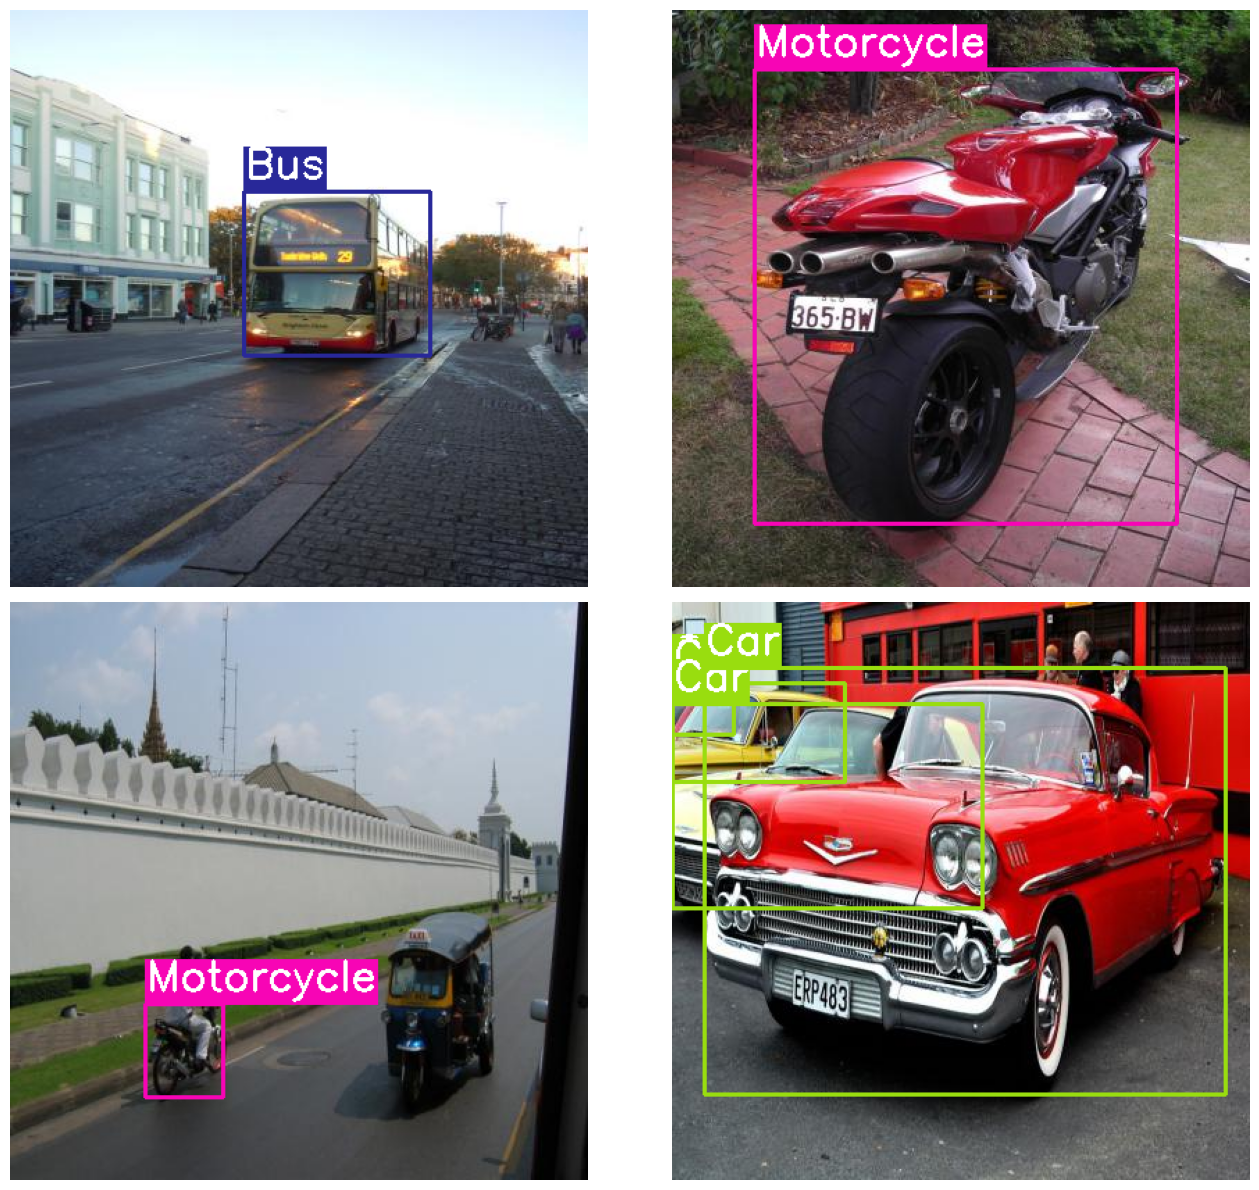

In [5]:
plot(image_paths='/kaggle/input/cars-detection/Cars Detection/train/images/*',
    label_paths='/kaggle/input/cars-detection/Cars Detection/train/labels/*',
    num_samples=4,
)

# YOLOV8

In [6]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 10.8 MB/s eta 0:00:00


In [7]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml") 

In [8]:
import wandb

wandb.login(key="6d8ec47cef04273e01e299f162c2d458244c941f")
results = model.train(data = "/kaggle/input/yamlfile/data.yaml", epochs=100)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/input/yamlfile/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

100%|██████████| 755k/755k [00:00<00:00, 36.0MB/s]
2024-09-22 13:24:24,091	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-22 13:24:25,378	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Currently logged in as: eid-osama. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240922_132436-yj28mt7k
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/eid-osama/YOLOv8
wandb: 🚀 View run at https://wandb.ai/eid-osama/YOLOv8/runs/yj28mt7k


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 174MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/cars-detection/Cars Detection/train/labels... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:02<00:00, 407.07it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/cars-detection/Cars Detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/cars-detection/Cars Detection/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 391.58it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/cars-detection/Cars Detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.37G      3.281      4.436      4.222         54        640: 100%|██████████| 55/55 [00:12<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


                   all        250        454    0.00221        0.5    0.00246   0.000975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.32G      3.211      4.204      3.999         45        640: 100%|██████████| 55/55 [00:10<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


                   all        250        454    0.00275      0.454    0.00281   0.000976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.32G      3.009      4.131      3.667         61        640: 100%|██████████| 55/55 [00:10<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

                   all        250        454    0.00338      0.522    0.00795    0.00197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.32G      2.848      4.059      3.419         58        640: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

                   all        250        454      0.403     0.0235     0.0106    0.00311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.31G      2.695      3.935      3.241         44        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


                   all        250        454    0.00902     0.0381     0.0106    0.00312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.32G      2.614      3.851      3.103         42        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


                   all        250        454      0.433       0.12     0.0289    0.00818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.33G      2.441      3.689      2.972         56        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


                   all        250        454      0.615     0.0235     0.0643     0.0167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.32G      2.305      3.628      2.862         55        640: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


                   all        250        454       0.43     0.0372     0.0327    0.00978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.31G      2.214      3.508      2.757         52        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


                   all        250        454     0.0267     0.0841     0.0363     0.0168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.33G      2.151      3.425       2.67         57        640: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


                   all        250        454      0.098     0.0794     0.0719     0.0273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.33G      2.024      3.352      2.589         43        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        250        454      0.326      0.124     0.0874     0.0408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.32G       2.01      3.246      2.549         49        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


                   all        250        454     0.0923      0.156     0.0699     0.0347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.32G      1.954      3.254      2.506         59        640: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


                   all        250        454      0.129      0.189      0.115     0.0529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.33G      1.938      3.141      2.464         56        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


                   all        250        454      0.226      0.129       0.12     0.0545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.32G      1.879      3.077      2.421         53        640: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


                   all        250        454      0.133      0.108     0.0989     0.0564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.32G       1.85      3.054      2.376         39        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


                   all        250        454      0.164      0.199      0.142      0.064

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.31G      1.826      2.935       2.32         53        640: 100%|██████████| 55/55 [00:10<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]


                   all        250        454      0.149       0.21      0.124     0.0539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.32G      1.759      2.873      2.295         54        640: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


                   all        250        454      0.155      0.208      0.133     0.0757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.32G      1.789      2.853      2.295         56        640: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        250        454      0.143      0.218      0.153     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.32G      1.737      2.849      2.255         37        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


                   all        250        454      0.225      0.304      0.189      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.31G      1.714      2.768      2.236         45        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


                   all        250        454      0.221      0.226      0.129     0.0678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.32G      1.725      2.718      2.242         49        640: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


                   all        250        454      0.176      0.199      0.122     0.0657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.32G      1.651      2.655      2.179         70        640: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]

                   all        250        454      0.209      0.209      0.157     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.32G      1.671      2.677      2.191         30        640: 100%|██████████| 55/55 [00:10<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


                   all        250        454      0.238      0.331      0.225      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.31G      1.637      2.627      2.147         46        640: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        250        454      0.233       0.23      0.166     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.32G      1.625      2.612      2.126         55        640: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        250        454      0.257      0.311      0.181     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.32G      1.629      2.574      2.134         53        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]


                   all        250        454      0.242      0.358       0.24      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.32G      1.589      2.474      2.085         51        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


                   all        250        454      0.206      0.299      0.209      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.31G      1.621        2.5      2.102         54        640: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


                   all        250        454      0.261      0.372      0.241      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.32G      1.566      2.448       2.08         62        640: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        250        454      0.271      0.251      0.215      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.32G      1.581      2.444      2.056         54        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


                   all        250        454      0.278       0.31      0.208      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.32G      1.538      2.387      2.037         36        640: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        250        454      0.321      0.312      0.246      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.31G      1.502      2.373      2.009         48        640: 100%|██████████| 55/55 [00:09<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


                   all        250        454      0.294      0.307      0.272      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.32G      1.537      2.376      2.007         48        640: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


                   all        250        454       0.23      0.368      0.248      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.32G      1.535      2.363      2.029         40        640: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


                   all        250        454      0.224      0.291      0.211      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.32G        1.5      2.314      1.986         42        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        250        454      0.298      0.351      0.289      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.31G      1.511      2.329      1.998         56        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


                   all        250        454      0.234      0.356      0.237      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.32G      1.472      2.273      1.971         49        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

                   all        250        454      0.368      0.301      0.228       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.32G      1.467      2.239      1.973         45        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        250        454      0.282      0.375      0.279      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.32G      1.476      2.241      1.964         39        640: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        250        454      0.322       0.41      0.325       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.31G      1.458      2.153      1.934         51        640: 100%|██████████| 55/55 [00:09<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


                   all        250        454      0.346      0.291      0.305      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.32G      1.436      2.187      1.931         45        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


                   all        250        454      0.335      0.337      0.309      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G      1.436      2.168      1.935         44        640: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]


                   all        250        454      0.313      0.402      0.309        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.32G      1.406      2.109       1.89         43        640: 100%|██████████| 55/55 [00:10<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]

                   all        250        454      0.353      0.334      0.308      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.31G       1.41      2.093      1.893         44        640: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]

                   all        250        454      0.372      0.412      0.345      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.32G      1.403      2.168      1.901         62        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

                   all        250        454      0.415      0.383      0.371      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.32G      1.388      2.067      1.872         48        640: 100%|██████████| 55/55 [00:10<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        250        454      0.388      0.438       0.35      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.32G      1.402      2.044      1.887         57        640: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]

                   all        250        454      0.329       0.41       0.35      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.31G      1.347      2.034      1.851         60        640: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]


                   all        250        454      0.404      0.377       0.36       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.32G      1.354      1.986      1.828         57        640: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]

                   all        250        454      0.371      0.374       0.34      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.32G      1.356      2.022      1.833         53        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        250        454      0.382        0.4      0.376      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.32G      1.332      1.995      1.835         51        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        250        454      0.354      0.464      0.385      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.31G      1.343      1.969      1.848         64        640: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]

                   all        250        454      0.294      0.384      0.327      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.32G      1.323      1.947        1.8         43        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]

                   all        250        454      0.423       0.42      0.389      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.32G      1.347      1.926      1.815         48        640: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


                   all        250        454      0.427      0.397      0.382      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.32G      1.315      1.922      1.784         39        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        250        454      0.366      0.321      0.309      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.31G      1.308      1.923      1.784         49        640: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        250        454      0.523      0.396      0.407      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.32G      1.289      1.884      1.772         56        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]

                   all        250        454       0.49       0.41       0.43      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.32G      1.278      1.856      1.771         59        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]


                   all        250        454      0.497      0.437       0.44      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.32G      1.301      1.861      1.757         44        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]

                   all        250        454      0.464      0.452       0.45        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.31G      1.287      1.839      1.766         54        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        250        454      0.374      0.459      0.394      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.32G       1.29      1.861      1.782         47        640: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


                   all        250        454      0.376      0.392      0.357      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.32G      1.267      1.801       1.74         55        640: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        250        454      0.447      0.452      0.417      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.32G      1.253      1.786      1.732         60        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


                   all        250        454      0.373      0.487      0.383      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.31G      1.235      1.763      1.741         51        640: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        250        454      0.539      0.458      0.432      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.32G       1.26      1.769      1.733         45        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        250        454      0.518      0.443      0.437      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.32G       1.26      1.777      1.733         45        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]


                   all        250        454       0.45      0.441      0.418      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.32G      1.242      1.734      1.722         59        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


                   all        250        454      0.459      0.408      0.408      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.31G      1.219      1.704      1.699         50        640: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

                   all        250        454      0.385      0.449       0.42      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.32G      1.229      1.684      1.705         61        640: 100%|██████████| 55/55 [00:10<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        250        454       0.52      0.437      0.427      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.32G      1.204      1.712      1.682         45        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        250        454      0.393      0.518      0.441       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.32G      1.191      1.641      1.684         38        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

                   all        250        454      0.633      0.349      0.405      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.31G      1.215      1.687      1.685         44        640: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        250        454       0.45      0.443      0.436      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.32G      1.175      1.633      1.662         47        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]

                   all        250        454      0.524      0.441      0.463      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.32G      1.198      1.675      1.659         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        250        454      0.564      0.427       0.48      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.32G      1.178      1.621      1.644         57        640: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]

                   all        250        454      0.526      0.413      0.439      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.31G      1.159      1.579      1.638         53        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        250        454      0.488      0.487      0.463      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.32G      1.169      1.625      1.654         60        640: 100%|██████████| 55/55 [00:10<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]

                   all        250        454      0.534      0.437      0.488      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.32G      1.166      1.569      1.638         48        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        250        454      0.509      0.445      0.452      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.32G      1.157      1.546      1.627         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]

                   all        250        454      0.492      0.459      0.448      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.31G      1.173      1.554      1.633         51        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        250        454      0.507      0.493      0.448      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.32G      1.166       1.56      1.641         43        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        250        454      0.613      0.418      0.468      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.32G      1.146      1.534      1.616         57        640: 100%|██████████| 55/55 [00:10<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        250        454      0.532      0.483      0.468      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.32G      1.134      1.513      1.627         51        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


                   all        250        454      0.562      0.457      0.479      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.31G      1.134      1.563      1.619         50        640: 100%|██████████| 55/55 [00:10<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]


                   all        250        454      0.642      0.415      0.483      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.32G      1.119       1.53      1.603         45        640: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]

                   all        250        454      0.651      0.438      0.513      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.32G      1.119      1.475      1.592         40        640: 100%|██████████| 55/55 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        250        454      0.486      0.542      0.489      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.32G      1.123      1.479      1.606         61        640: 100%|██████████| 55/55 [00:10<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]

                   all        250        454      0.595      0.424      0.479      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.31G      1.114      1.483      1.591         38        640: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        250        454      0.598      0.489      0.507      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.32G      1.111      1.462      1.585         58        640: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        250        454      0.573      0.474      0.487      0.332


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.32G      1.014      1.306      1.544         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        250        454      0.602      0.472      0.502      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.32G     0.9749      1.222      1.517         20        640: 100%|██████████| 55/55 [00:10<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        250        454      0.574      0.487      0.491      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.31G     0.9516       1.13      1.488         27        640: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]

                   all        250        454      0.583      0.466       0.51       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.32G     0.9316       1.11      1.461         28        640: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


                   all        250        454      0.634      0.439      0.491      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.32G      0.925      1.108      1.488         24        640: 100%|██████████| 55/55 [00:09<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


                   all        250        454      0.593       0.44      0.496      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.32G     0.9366      1.122      1.461         22        640: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        250        454      0.537      0.457      0.499      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.31G     0.9165      1.121      1.452         20        640: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]

                   all        250        454       0.66      0.406      0.496       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.32G     0.9033      1.083      1.441         28        640: 100%|██████████| 55/55 [00:10<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]


                   all        250        454      0.554      0.457       0.49      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.32G     0.9165      1.064      1.444         20        640: 100%|██████████| 55/55 [00:09<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all        250        454      0.615      0.443      0.503      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.32G       0.89      1.062      1.431         20        640: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        250        454      0.617      0.437      0.501      0.352



100 epochs completed in 0.351 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        250        454      0.651      0.438      0.513      0.352
             Ambulance         50         64      0.758      0.719      0.758      0.614
                   Bus         30         46      0.842      0.565      0.671      0.476
                   Car         90        238      0.579      0.254      0.331      0.209
            Motorcycle         42         46      0.608      0.478      0.536      0.276
                 Truck         38         60      0.467      0.176       0.27      0.184
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▁▁▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▅▇▆▆▇▇▇▇▇▇▇███████
wandb:     metrics/mAP50-95(B) ▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▄▅▅▅▆▆▆▅▇▆▆▇▆▇▇▇▇▇▇██████
wandb:    metrics/precision(B) ▁▁▆▆▄▂▃▃▃▃▄▃▄▃▄▄▅▅▅▅▅▅▅▆▅▅▆▅█▇▆▆█▇▆▇▇███
wandb:       metrics/recall(B) ▇█▂▁▂▃▃▃▄▃▅▅▅▆▅▆▅▅▆▆▆▆▅▇▇▇▇▇▅▇▇▇▆▇█▇▇▇▆▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▆▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:          train/cls_loss █▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:          train/dfl_loss █▇▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb:            val/box_loss ██▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁

# Predict Images

In [9]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt source='/kaggle/input/mooo/tensorflow2/default/1/__results___21_0.png'

Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /kaggle/input/mooo/tensorflow2/default/1/__results___21_0.png: 640x640 6 Cars, 8.1ms
Speed: 6.1ms preprocess, 8.1ms inference, 142.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


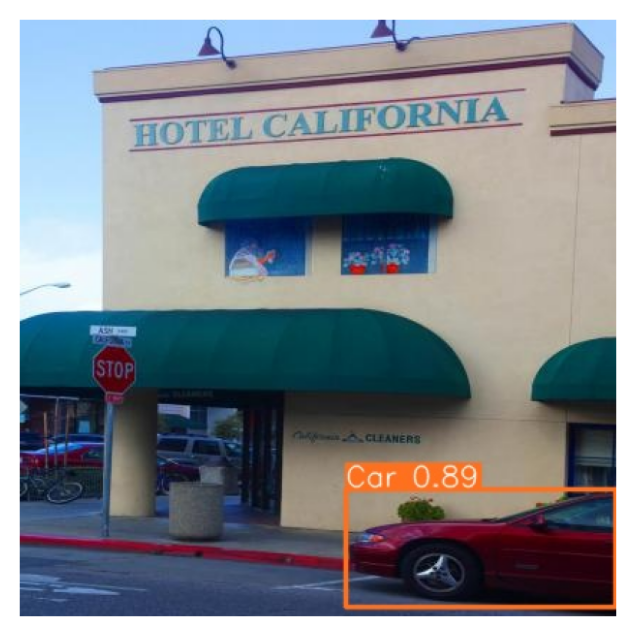

In [10]:
img_path = '/kaggle/input/mooo/tensorflow2/default/1/__results___21_0.png'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()